# 5. Capstone Project: Data Preparation II

***

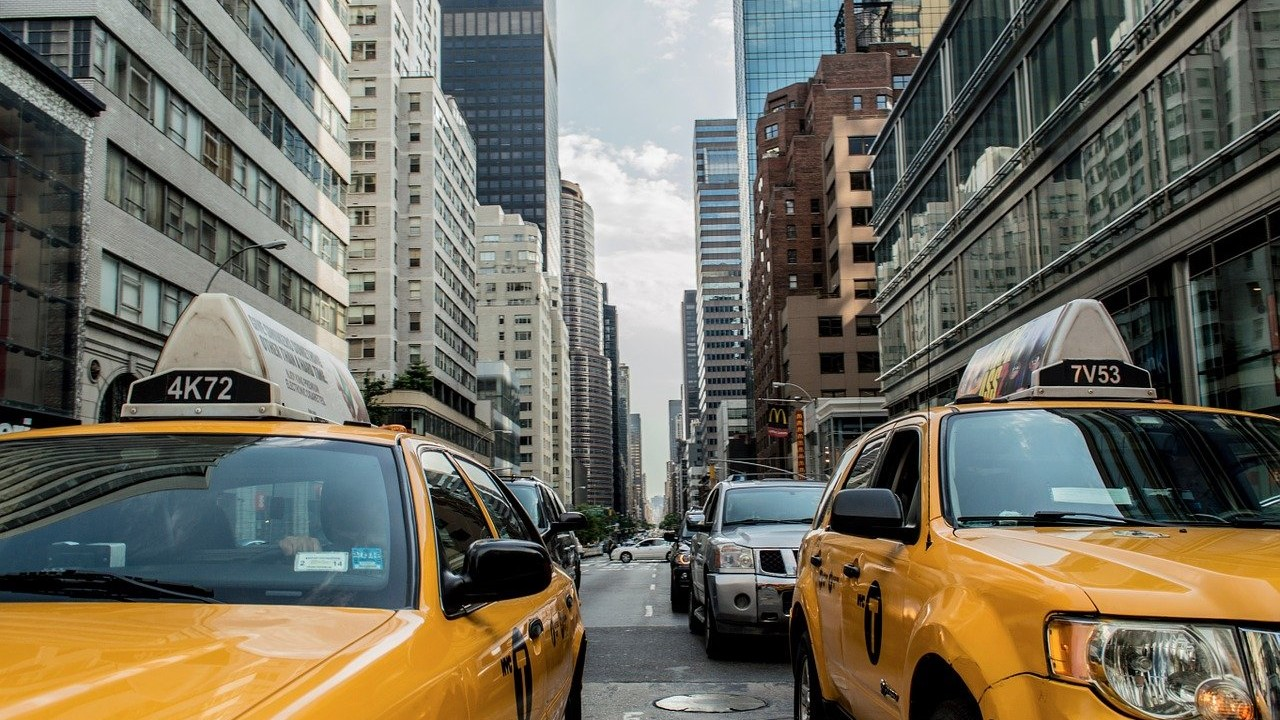

##  Goals

### Project:
Find out where and when traffic congestion is highest and lowest in New York City. Then build different machine learning models that can predict cab travel times in New York City, compare their performance, and explore the potential of additional features such as weather forecasts and holidays to improve the models' predictive performance.

### Section:
In this section, data will be prepared for the next steps, i.e., exploratory data analysis and machine learning model building. First, we will collect and import the necessary datasets. Next, we will review each of these datasets to fully understand the data and its structure, including the different variables available, their format, and their relevance to the project. Finally, we will perform data cleaning and manipulation, as well as feature engineering, and encoding.

The data preparation will be divided into two subsections, the first dedicated to the external datasets (Data Preparation Part I) and the second to the New York City Taxi Trip data set (Data Preparation Part II). Finally, external datasets will be merged with the primary one.

## Data
### External Datasets:
- Weather Forecast: The 2018 NYC weather forecast was collected from the [National Weather Service Forecast Office](https://w2.weather.gov/climate/index.php?wfo=okx) website. Daily measurements were taken from January to December 2018 in Central Park. These measures are given in imperial units and include daily minimum and maximum temperatures, precipitations, snowfall, and snow depth.

- Holidays: The 2018 NYC holidays list was collected from the [Office Holiday](https://www.officeholidays.com/countries/usa/new-york/2021) website. The dataset contains the name, date, and type of holidays for New York.

- Taxi Zones: The NYC Taxi Zones dataset was collected from the [NYC Open Data](https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc) website. It contains the pickup and drop-off zones (Location IDs) for the Yellow, Green, and FHV Trip Records. The taxi zones are based on the NYC Department of City Planning’s Neighborhood.

### Primary Datasets:

- Taxi Trips: The 2018 NYC Taxi Trip dataset was collected from the [Google Big Query](https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-tlc-trips?project=jovial-monument-300209&folder=&organizationId=) platform. The dataset contains more than 100'000'000 Yellow Taxi Trip records for 2018 and contains an extensive amount of variables including the pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

***
## Table of Content:
    1. Data Preparation
        1.1 External Datasets
            1.1.1 Weather Forecast Dataset
            1.1.2 Holidays Dataset
            1.1.3 Taxi Zones Dataset
        1.2 Primary Dataset
            1.2.1 Taxi Trips Dataset
    2. Exploratory Data Analysis
        2.1 Primary Dataset
            2.1.1 Temporal Analysis
            2.1.2 Spatial & Temporal Analysis
        2.2 External Datasets
            2.2.1 Temporal Analysis of weather data
            2.2.2 Temporal Analysis of holidays data
        2.3 Combined Dataset
            2.3.1 Overall Features Correlation
    3. Machine Learning Models

***
## Python Libraries and Magic commands Import

In [1]:
# Import data processing libraries
import pandas as pd
import numpy as np

# Import Visualization librairies
import matplotlib.pyplot as plt

# Import machine learning libraries
from sklearn.model_selection import train_test_split

In [2]:
# Set up magic commands
%matplotlib inline

***
## Data Import

In [3]:
# Import the weather forecasts dataset
weather_df = pd.read_pickle(r'data/processed/weather.pickle')

# Import the holidays dataset
holidays_df = pd.read_pickle(r'data/processed/holidays.pickle')

# Import the zones dataset
zones_df = pd.read_pickle(r'data/processed/zones.pickle')

***
## Functions import

In [4]:
# Define a function that transform column headers to titles
def to_title(data, sep='_'):
    return [s.replace(sep, ' ').title() for s in data]

In [5]:
# Define a function that compute and display descriptive statistics for selected columns
def outliers_distribution(data, columns, statistics, percentiles):

    # Create an empty dictionnary to collect the columns' descriptive statistics
    frame = {}

    # Iterate over the given numerical columns
    for column in columns:

        # Compute the descriptive statistics for records above the column's given percentile
        output = (
            data.loc[data[column] > percentiles[column].iloc[0], column]
            .describe()[statistics]
            .round(2)
        )

        # Add the column's descriptive statistics to the dictionnary
        frame[column] = output

    # Return the columns' descriptive statistics as a data frame
    return pd.DataFrame(frame)

In [6]:
# Define a function that display scatter plots of selected numerical columns
def plot_scatter(data, columns, colnames, variable, ncols=1, nrows=1):

    varname = variable.replace("_", " ").title()

    # Create a figure with n columns and rows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, sharey=True, figsize=(ncols * 5, nrows * 5)
    )

    # Flatten axes for 2D figures
    if ncols > 1 or nrows > 1:
        axes = axes.ravel()

    # Generate the plots
    for ax, col, colname in zip(axes, columns, colnames):
        ax.scatter(x=col, y=variable, s=5, data=data)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.set_ylim(0)
        ax.tick_params(labelsize=14)
        ax.set_xlabel(colname, fontsize=14)
        ax.set_ylabel(varname, fontsize=14)
        ax.set_title(f"{varname} vs {colname}", fontsize=16)
        ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)
        
    # Display the figure
    plt.show()

In [7]:
# Define a function that display individual boxplot of selected numerical columns
def plot_boxplot(data, columns, colnames, ncols=1, nrows=1):
    # Create a figure with n columns and rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

    # Define the fliers props
    flierprops = dict(markerfacecolor='C0', markersize=5, markeredgecolor='none')

    # Flatten axes for 2D figures
    if ncols > 1 or nrows > 1:
        axes = axes.ravel()
    
    # Generate the plots
    for ax, col, colname in zip(axes, columns, colnames):
        ax.boxplot(data[col], flierprops=flierprops)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks([])
        ax.tick_params(labelsize=14)
        ax.set_xlabel(colname, fontsize=14)
        ax.set_title(colname + ' Distribution', fontsize=16)
        ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Display the figure
    plt.show()

In [8]:
# Define a function that display individual violinplot of selected numerical columns
def plot_violinplot(data, columns, colnames, ncols=1, nrows=1, color="C0"):

    # Create a figure with n columns and rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

    # Flatten axes for 2D figures
    if ncols > 1 or nrows > 1:
        axes = axes.ravel()

    # Generate the plots
    for ax, col, colname in zip(axes, columns, colnames):
        violin_plot = ax.violinplot(data[col])

        # Change color of the violin plot
        for pc in violin_plot["bodies"]:
            pc.set_facecolor(color)
            pc.set_edgecolor(color)

        violin_plot["cbars"].set_edgecolor("black")
        violin_plot["cmins"].set_edgecolor("black")
        violin_plot["cmaxes"].set_edgecolor("black")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        ax.tick_params(labelsize=14)
        ax.set_title(colname, fontsize=16)
        ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Display the figure
    plt.show()

***

# 1. Data Preparation

## 1.2 Data Preparation: NYC taxi trip dataset
### Goal:
Explore a subset (10%) of the 2018 NYC yellow taxi trip dataset dataset and perform data cleaning and manipulation, as well as feature engineering and encoding if needed.
### Code:

In [9]:
# # Create a global variable containing the credentials to query Google Big Query Servers
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'credentials\exts-ml-5e5656f1d391.json'

# # Create an empty data frame
# records_df = pd.DataFrame()

# # Create a row offest
# row_offset = 0

# # Create a row limit
# row_limit = 10000000

# # Create a row offest counter
# row_counter = 10000000

# # Get the NYC taxi dataset in chuncks of 10M to avoid insufficient memory issues
# while (row_counter == row_limit):

#     print(f'Fetching rows from {row_offset} to {row_offset + row_counter}:')

#     # Create a query to fetch and transform the NYC taxi dataset from the Google Big Query servers
#     query = f'''
#     SELECT
#         pickup_datetime,
#         dropoff_datetime,
#         passenger_count,
#         trip_distance,
#         tolls_amount,
#         fare_amount,
#         pickup_location_id,
#         dropoff_location_id,
#         TIME_DIFF(pickup_datetime, dropoff_datetime, MINUTE) as trip_duration;
#     FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018`
#     LIMIT {row_limit}
#     OFFSET {row_offset};
#     '''
#     # Get a chunck of the Google Big Query servers
#     df = pd.read_gbq(query, dialect='standard', progress_bar_type='tqdm')

#     # Get a random sample of 10% of the NYC taxi dataset chunck
#     records_df = records_df.append(df.sample(frac=0.01, replace=False, random_state=0), ignore_index = True)

#     # Update the row counter with the current data frame lenght
#     row_counter = len(df.index)

#     # Update the row offest
#     row_offset += row_counter

In [10]:
# Open data frame
records_df = pd.read_pickle('raw_data.pickle')

records_df['trip_duration'] = (
    records_df.dropoff_datetime - records_df.pickup_datetime
).dt.seconds / 60

records_df['pickup_location_id'] = records_df['pickup_location_id'].astype('int64')
records_df['dropoff_location_id'] = records_df['dropoff_location_id'].astype('int64')

In [11]:
# Display the first five rows of the data frame
records_df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,tolls_amount,fare_amount,pickup_location_id,dropoff_location_id,trip_duration
0,2018-04-26 12:11:19,2018-04-26 12:24:34,3,8.90,2.64,25.0,143,220,13.250000
1,2018-06-19 10:02:34,2018-06-19 10:45:46,1,15.84,0.00,48.0,138,85,43.200000
2,2018-09-05 13:51:40,2018-09-05 14:33:07,1,11.10,5.76,37.5,138,142,41.450000
3,2018-05-11 10:20:58,2018-05-11 10:46:27,2,8.49,0.00,27.5,45,41,25.483333
4,2018-12-16 18:21:08,2018-12-16 18:46:04,6,7.79,0.00,24.5,229,106,24.933333


In [12]:
# Display a quick description of the data frame
records_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122346 entries, 0 to 1122345
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   pickup_datetime      1122346 non-null  datetime64[ns]
 1   dropoff_datetime     1122346 non-null  datetime64[ns]
 2   passenger_count      1122346 non-null  int64         
 3   trip_distance        1122346 non-null  float64       
 4   tolls_amount         1122346 non-null  float64       
 5   fare_amount          1122346 non-null  float64       
 6   pickup_location_id   1122346 non-null  int64         
 7   dropoff_location_id  1122346 non-null  int64         
 8   trip_duration        1122346 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(3)
memory usage: 77.1 MB


**Notes:** the data frame contains 11'223'463 entries, or 1% of all 2018 NYC taxi records. Most numeric columns are the wrong type and will need to be converted from String (Object) to float or integer. The locations columns will be converted to categorical values to save memory and signal other python libraries that these columns should be treated as categorical variables. Also, the info() function did not return the number of rows containing NAs, and we will first need to check for missing values before going further with the data cleaning and feature engineering/encoding.

In [13]:
# Display the number of empty cells in each column of the data frame
records_df.isna().sum()

pickup_datetime        0
dropoff_datetime       0
passenger_count        0
trip_distance          0
tolls_amount           0
fare_amount            0
pickup_location_id     0
dropoff_location_id    0
trip_duration          0
dtype: int64

**Notes:** most machine learning algorithms do not support missing values, and handling them is a crucial preprocessing step. Fortunately, the dataset does not contain any.

In [14]:
# Define numerical columns to be converted to float
num_cols = ['trip_distance', 'tolls_amount', 'fare_amount', 'trip_duration']

# Convert numerical columns to float
records_df[num_cols] = records_df[num_cols].astype('float64')

# Display a quick description of the data frame
records_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122346 entries, 0 to 1122345
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   pickup_datetime      1122346 non-null  datetime64[ns]
 1   dropoff_datetime     1122346 non-null  datetime64[ns]
 2   passenger_count      1122346 non-null  int64         
 3   trip_distance        1122346 non-null  float64       
 4   tolls_amount         1122346 non-null  float64       
 5   fare_amount          1122346 non-null  float64       
 6   pickup_location_id   1122346 non-null  int64         
 7   dropoff_location_id  1122346 non-null  int64         
 8   trip_duration        1122346 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(3)
memory usage: 77.1 MB


**Notes:** the columns have been correctly converted to float. As before, the values in the numeric columns will be converted to metric units. In addition, columns containing dates will be examined to see if any records occurred before or after 2018.

In [15]:
# Convert the trip distance from miles to kilometers
records_df["trip_distance"] = np.multiply(records_df["trip_distance"], 1.60934)

# Display the records with pickup dates out of the date range (2018.01.01 - 2018.01.01)
records_df[
    (records_df['pickup_datetime'] < '2018.01.01')
    | (records_df['pickup_datetime'] > '2019.01.01')
]

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,tolls_amount,fare_amount,pickup_location_id,dropoff_location_id,trip_duration
47651,2008-12-31 23:04:03,2008-12-31 23:52:46,3,8.159354,0.00,30.5,262,43,48.716667
88284,2009-01-01 19:00:20,2009-01-01 19:31:20,1,20.486898,0.00,36.5,138,132,31.000000
146270,2009-01-01 01:20:49,2009-01-01 01:54:23,1,28.372664,5.76,52.0,132,107,33.566667
199646,2017-09-18 10:55:06,2017-09-18 10:56:07,1,0.000000,0.00,1.0,264,264,1.016667
232220,2009-01-01 00:02:33,2009-01-01 00:11:27,1,1.303565,0.00,6.5,163,230,8.900000
239099,2017-12-31 20:54:59,2017-12-31 21:05:32,6,2.703691,0.00,9.0,87,148,10.550000
324569,2008-12-31 23:08:11,2008-12-31 23:19:10,2,2.043862,0.00,8.0,230,170,10.983333
377679,2009-01-01 00:03:46,2009-01-01 00:07:09,2,0.000000,0.00,4.0,193,193,3.383333
384671,2019-02-13 06:20:00,2019-02-13 06:29:04,6,2.446197,0.00,8.0,186,137,9.066667
475996,2019-01-01 00:22:41,2019-01-01 00:32:06,2,2.269169,0.00,8.0,161,140,9.416667


**Notes:** more than a dozen records had dates before or after 2018. These records will be removed from the data frame.

In [16]:
# Remove records with pickup dates below 2018.01.01 and above 2018.01.01
records_df = records_df[
    (records_df['pickup_datetime'] >= '2018.01.01')
    & (records_df['pickup_datetime'] <= '2019.01.01')
]

# Display a quick description of the data frame
records_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122330 entries, 0 to 1122345
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   pickup_datetime      1122330 non-null  datetime64[ns]
 1   dropoff_datetime     1122330 non-null  datetime64[ns]
 2   passenger_count      1122330 non-null  int64         
 3   trip_distance        1122330 non-null  float64       
 4   tolls_amount         1122330 non-null  float64       
 5   fare_amount          1122330 non-null  float64       
 6   pickup_location_id   1122330 non-null  int64         
 7   dropoff_location_id  1122330 non-null  int64         
 8   trip_duration        1122330 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(3)
memory usage: 85.6 MB


**Notes:** the 16 records with dates out of range were removed from the data frame.

In [17]:
# Display some descriptive statistics
records_df.describe().round(2)

,passenger_count,trip_distance,tolls_amount,fare_amount,pickup_location_id,dropoff_location_id,trip_duration
count,1122330.00,1122330.00,1122330.00,1122330.00,1122330.00,1122330.00,1122330.00
mean,1.60,4.64,0.34,13.02,163.23,161.47,17.24
std,1.24,5.98,1.78,189.30,66.42,70.36,66.13
min,0.00,0.00,-18.00,-275.00,1.00,1.00,0.00
25%,1.00,1.54,0.00,6.50,114.00,107.00,6.58
50%,1.00,2.57,0.00,9.00,162.00,162.00,10.97
75%,2.00,4.72,0.00,14.50,233.00,233.00,18.08
max,9.00,171.31,770.76,200005.50,265.00,265.00,1439.97


**Notes:** the numerical columns appear to contain extreme and erroneous values. First, according to the [Official NYC Taxi FAQ](https://www1.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page): "the maximum number of passengers allowed by law in a yellow taxi is four in a four-passenger taxi or five in a five-passenger taxi." Trips with more than five passengers are either errors or are the result of taxi drivers picking up additional passengers en route to their final destination. These records will be removed from the data frame. In addition, some records have negative values for distance traveled, toll amount and fare amount, as well as values well above their 75th percentile. These extreme and erroneous records will also be removed from the database. Finally, records with zero number of trips, zero distance traveled, and zero travel time will be deleted from the database.

In [18]:
# Define the name of numerical columns
num_cols = [
    'passenger_count',
    'trip_distance',
    'tolls_amount',
    'fare_amount',
    'trip_duration',
]

# Define the name of numerical columns
num_colnames = to_title(num_cols)

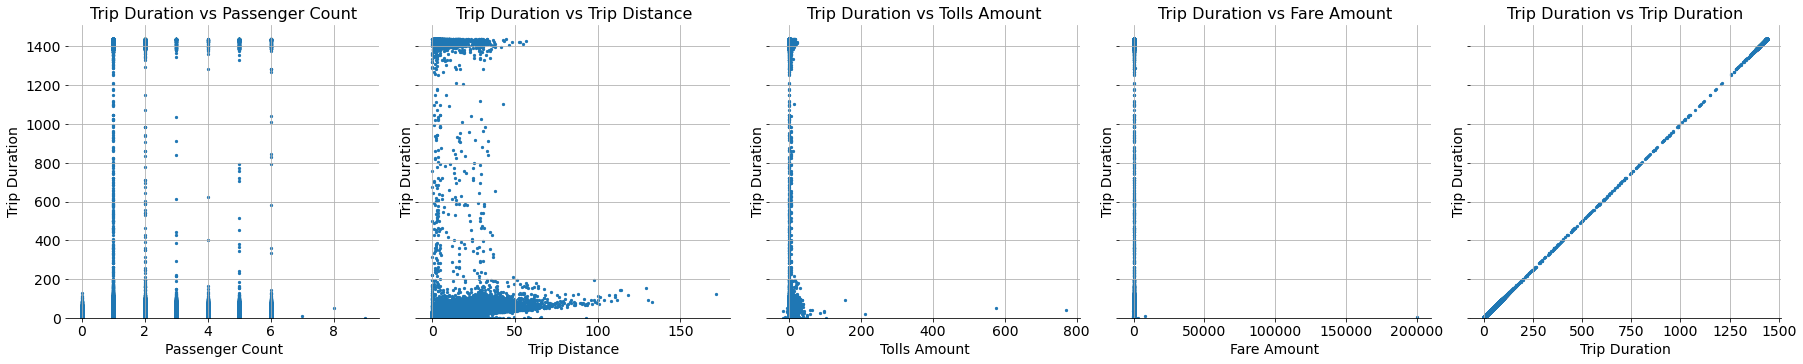

In [19]:
# Display scatterplot of numerical columns
plot_scatter(records_df, num_cols, num_colnames, 'trip_duration', ncols=len(num_cols))

**Notes:**

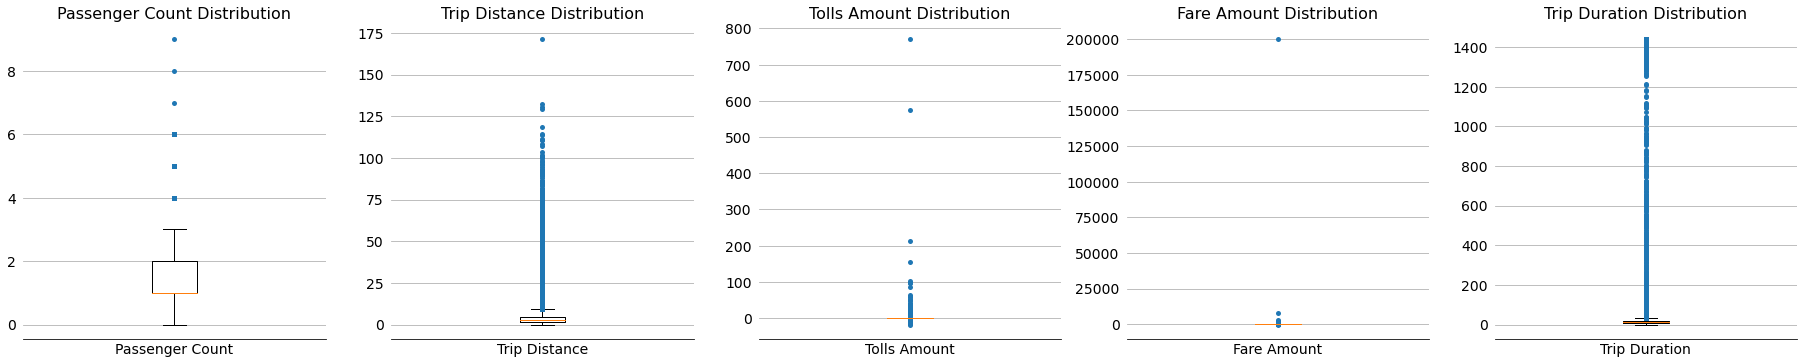

In [20]:
# Display boxplots of numerical columns
plot_boxplot(records_df, num_cols, num_colnames, ncols=len(num_cols))

**Notes:** 

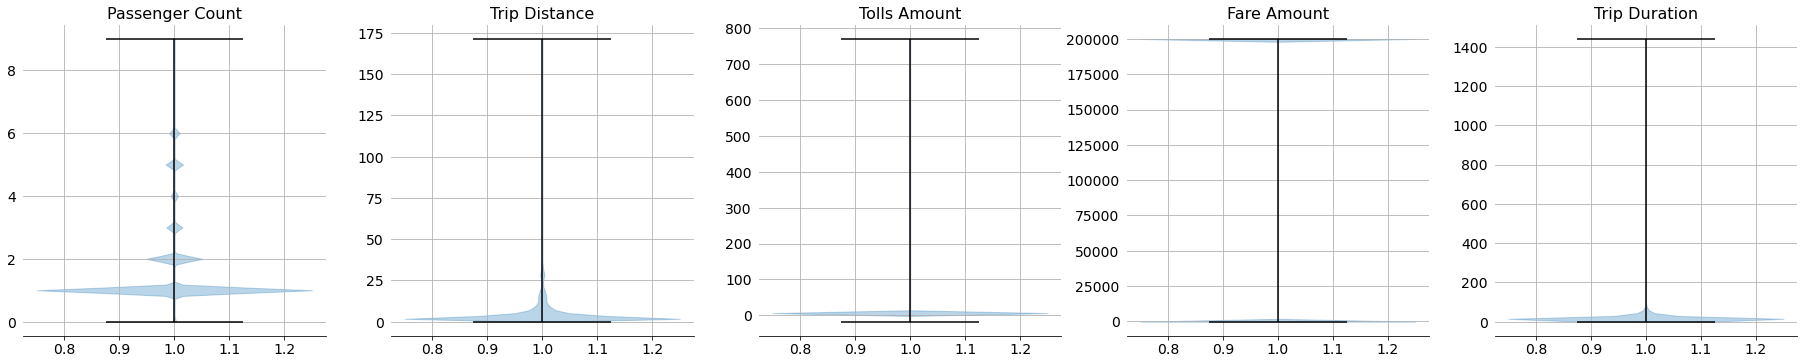

In [21]:
# Display violinplots of numerical columns
plot_violinplot(records_df, num_cols, num_colnames, ncols=len(num_cols))

**Notes:** 

In [22]:
# Compute the numerical columns' 75, 95, and 99th percentiles
percentiles_df = records_df.quantile([0.75, 0.95, 0.99])[num_cols].reset_index()

# Display the numerical columns' 75, 95, and 99th percentiles
percentiles_df

,index,passenger_count,trip_distance,tolls_amount,fare_amount,trip_duration
0,0.75,2.0,4.715366,0.00,14.5,18.083333
1,0.95,5.0,17.187751,5.76,36.0,36.950000
2,0.99,6.0,30.368246,5.76,52.0,61.816667


**Notes:**

In [23]:
# Define the descriptive statistics to display
perc_statistics = ['count', 'mean', 'std', 'min', 'max']

In [24]:
# Get the numerical columns' 75th percentiles
perc_75 = percentiles_df[percentiles_df['index'] == 0.75]

# Compute and display descriptive statistics for records above the column's 75th percentile
outliers_distribution(records_df, num_cols, perc_statistics, perc_75)

,passenger_count,trip_distance,tolls_amount,fare_amount,trip_duration
count,150381.00,280562.00,60274.00,267833.00,280121.00
mean,4.43,12.05,6.25,28.56,41.92
std,1.13,8.14,4.71,387.06,129.04
min,3.00,4.73,0.01,14.55,18.10
max,9.00,171.31,770.76,200005.50,1439.97


**Notes:**

In [25]:
# Get the numerical columns' 95th percentiles
perc_95 = percentiles_df[percentiles_df['index'] == 0.95]

# Compute and display descriptive statistics for records above the column's 95th percentile
outliers_distribution(records_df, num_cols, perc_statistics, perc_95)

,passenger_count,trip_distance,tolls_amount,fare_amount,trip_duration
count,30664.00,56104.00,3698.00,55393.00,56111.00
mean,6.00,25.75,14.53,54.99,110.49
std,0.02,6.96,16.91,850.53,277.76
min,6.00,17.20,5.77,36.04,36.97
max,9.00,171.31,770.76,200005.50,1439.97


**Notes:**

In [26]:
# Get the numerical columns' 99th percentiles
perc_99 = percentiles_df[percentiles_df['index'] == 0.99]

# Compute and display descriptive statistics for records above the column's 99th percentile
outliers_distribution(records_df, num_cols, perc_statistics, perc_99)

,passenger_count,trip_distance,tolls_amount,fare_amount,trip_duration
count,3.0,11208.00,3698.00,8727.00,11214.00
mean,8.0,35.23,14.53,97.53,369.75
std,1.0,7.35,16.91,2142.37,549.42
min,7.0,30.38,5.77,52.06,61.83
max,9.0,171.31,770.76,200005.50,1439.97


**Notes:** [Official NYC Taxi FAQ](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page) double to consider for return or compensate for high traffic 

In [27]:
# Discards records with passenger counts above the 95th percentile and below or equal to 0
records_df = records_df.loc[
    (records_df['passenger_count'] <= percentiles_df['passenger_count'].iloc[1])
    & (records_df['passenger_count'] > 0)
]

# Discards records with toll amounts above the 99th percentile and below or equal to 0
records_df = records_df.loc[
    (records_df['trip_distance'] <= percentiles_df['trip_distance'].iloc[2])
    & (records_df['trip_distance'] > 0)
]

# Discards records with tolls amounts above the 99th percentile and below 0
records_df = records_df.loc[
    (records_df['tolls_amount'] <= percentiles_df['tolls_amount'].iloc[2])
    & (records_df['trip_distance'] >= 0)
]

# Discards records with fare amounts above the 99th percentile and below 0
records_df = records_df.loc[
    (records_df['fare_amount'] <= percentiles_df['fare_amount'].iloc[2])
    & (records_df['fare_amount'] > 0)
]

# Discards records with trip duration above the 99 percentile and below 1
records_df = records_df.loc[
    (records_df['trip_duration'] <= percentiles_df['trip_duration'].iloc[2])
    & (records_df['trip_duration'] > 1)
]

# Display some descriptive statistics
records_df.describe().round(2)

,passenger_count,trip_distance,tolls_amount,fare_amount,pickup_location_id,dropoff_location_id,trip_duration
count,1047750.00,1047750.00,1047750.00,1047750.00,1047750.00,1047750.00,1047750.00
mean,1.49,4.21,0.24,11.93,163.52,161.75,13.52
std,1.01,4.78,1.14,8.73,66.54,69.94,9.71
min,1.00,0.02,0.00,0.01,1.00,1.00,1.02
25%,1.00,1.56,0.00,6.50,114.00,112.00,6.62
50%,1.00,2.57,0.00,9.00,162.00,162.00,10.87
75%,2.00,4.54,0.00,14.00,233.00,233.00,17.58
max,5.00,30.37,5.76,52.00,265.00,265.00,61.82


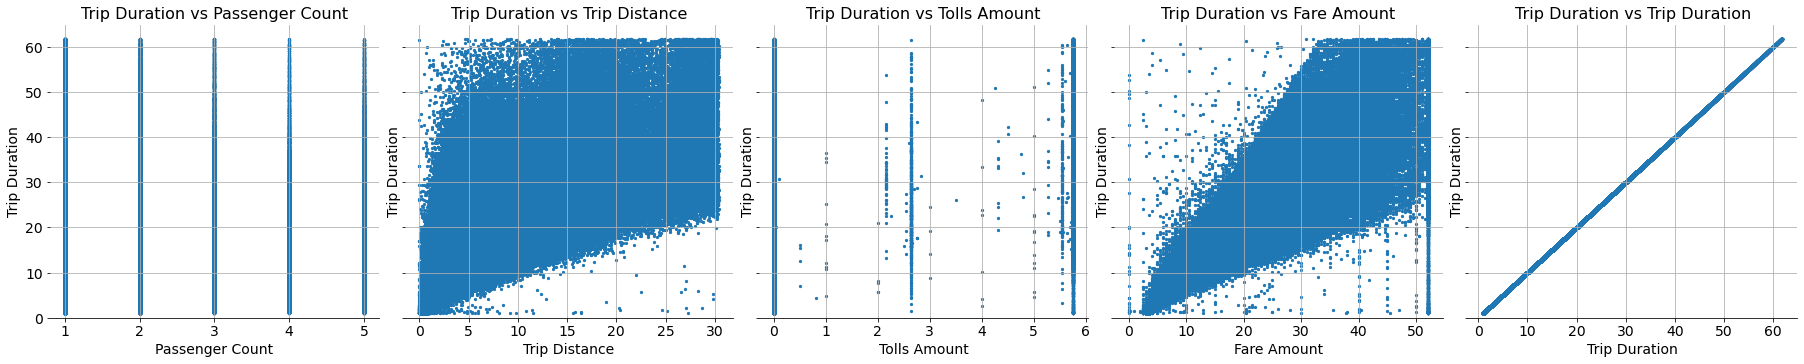

In [28]:
# Display scatterplots of numerical columns
plot_scatter(records_df, num_cols, num_colnames, 'trip_duration', ncols=len(num_cols))

**Notes:**

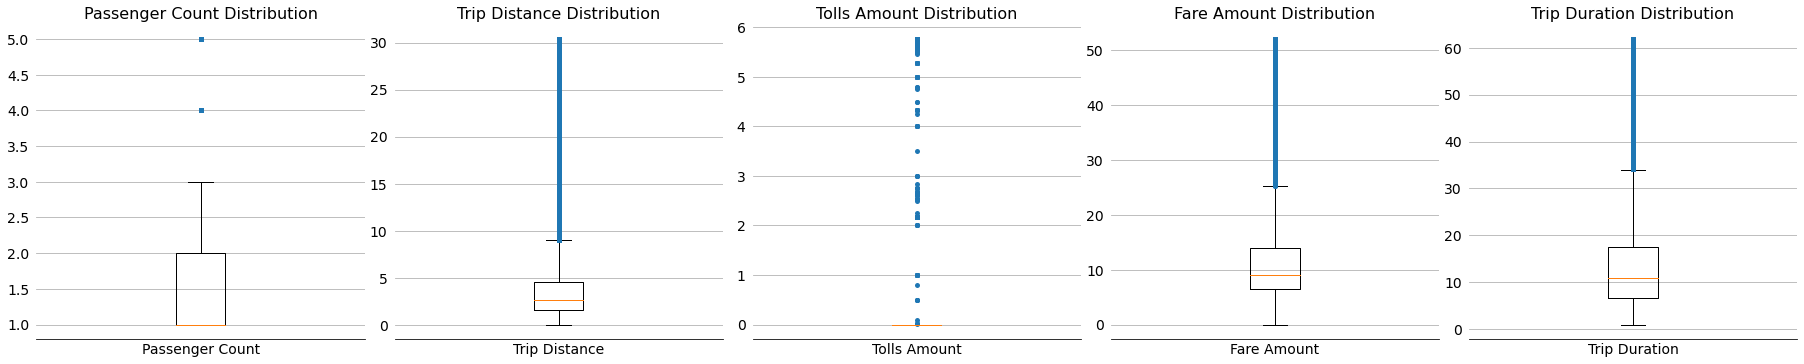

In [29]:
# Display boxplots of numerical columns
plot_boxplot(records_df, num_cols, num_colnames, ncols=len(num_cols))

**Notes:**

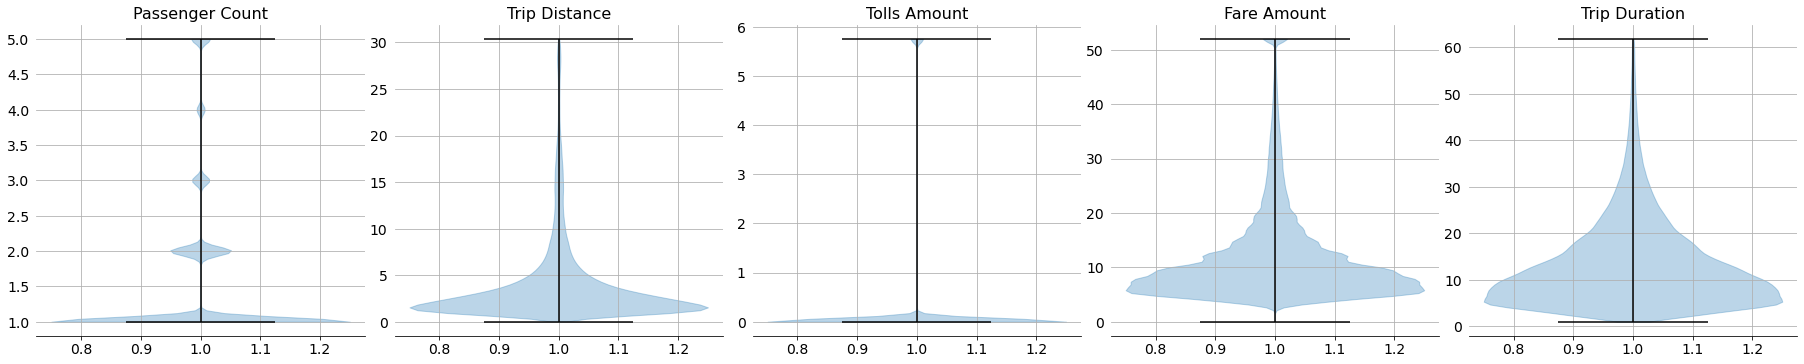

In [30]:
# Display violinplots of numerical columns
plot_violinplot(records_df, num_cols, num_colnames, ncols=len(num_cols))

**Notes:**

In [31]:
# Add a new column containing the date
records_df["pickup_date"] = records_df["pickup_datetime"].dt.date

# Add a new column containing the month of the year
records_df["pickup_month"] = records_df["pickup_datetime"].dt.month

# Add a new column containing the week of the year
records_df["pickup_week"] = records_df["pickup_datetime"].dt.isocalendar().week

# Add a new column containing the day of the year
records_df["pickup_yearday"] = records_df["pickup_datetime"].dt.dayofyear

# Add a new column containing the weekday of the week
records_df["pickup_weekday"] = records_df["pickup_datetime"].dt.weekday

# Add a new column containing the type of weekday (week=0, weekend=1)
records_df["pickup_weekday_type"] = np.where(records_df["pickup_weekday"] < 5, 0, 1)

# Add a new column containing the hour of the day
records_df["pickup_hour"] = records_df["pickup_datetime"].dt.hour

# Add a new column containing the type of hour (night=0, day=1)
records_df["pickup_hour_type"] = np.where(
    (records_df["pickup_hour"] < 6) | (records_df["pickup_hour"] > 21), 0, 1
)

# Display the first five rows of the data frame
records_df.head(20)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,tolls_amount,fare_amount,pickup_location_id,dropoff_location_id,trip_duration,pickup_date,pickup_month,pickup_week,pickup_yearday,pickup_weekday,pickup_weekday_type,pickup_hour,pickup_hour_type
0,2018-04-26 12:11:19,2018-04-26 12:24:34,3,14.323126,2.64,25.0,143,220,13.250000,2018-04-26,4,17,116,3,0,12,1
1,2018-06-19 10:02:34,2018-06-19 10:45:46,1,25.491946,0.00,48.0,138,85,43.200000,2018-06-19,6,25,170,1,0,10,1
2,2018-09-05 13:51:40,2018-09-05 14:33:07,1,17.863674,5.76,37.5,138,142,41.450000,2018-09-05,9,36,248,2,0,13,1
3,2018-05-11 10:20:58,2018-05-11 10:46:27,2,13.663297,0.00,27.5,45,41,25.483333,2018-05-11,5,19,131,4,0,10,1
5,2018-08-09 19:42:24,2018-08-09 20:14:05,1,18.185542,0.00,35.0,173,144,31.683333,2018-08-09,8,32,221,3,0,19,1
6,2018-05-19 00:12:43,2018-05-19 00:48:41,2,16.672762,0.00,36.0,114,244,35.966667,2018-05-19,5,20,139,5,1,0,0
7,2018-06-05 17:47:07,2018-06-05 18:11:32,2,5.632690,0.00,16.5,50,234,24.416667,2018-06-05,6,23,156,1,0,17,1
8,2018-06-23 12:53:00,2018-06-23 13:27:56,1,25.862094,0.00,45.0,132,37,34.933333,2018-06-23,6,25,174,5,1,12,1
9,2018-10-08 16:00:22,2018-10-08 16:32:17,1,15.353104,5.76,31.5,138,186,31.916667,2018-10-08,10,41,281,0,0,16,1
12,2018-12-16 21:35:01,2018-12-16 21:57:31,1,17.670553,5.76,31.5,138,170,22.500000,2018-12-16,12,50,350,6,1,21,1


**Notes:** [tomtom website](https://www.tomtom.com/en_gb/traffic-index/new-york-traffic/)

In [32]:
# Display a quick description of the data frame
records_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047750 entries, 0 to 1122345
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   pickup_datetime      1047750 non-null  datetime64[ns]
 1   dropoff_datetime     1047750 non-null  datetime64[ns]
 2   passenger_count      1047750 non-null  int64         
 3   trip_distance        1047750 non-null  float64       
 4   tolls_amount         1047750 non-null  float64       
 5   fare_amount          1047750 non-null  float64       
 6   pickup_location_id   1047750 non-null  int64         
 7   dropoff_location_id  1047750 non-null  int64         
 8   trip_duration        1047750 non-null  float64       
 9   pickup_date          1047750 non-null  object        
 10  pickup_month         1047750 non-null  int64         
 11  pickup_week          1047750 non-null  UInt32        
 12  pickup_yearday       1047750 non-null  int64         
 1

In [33]:
# Convert pickup date to datetime
records_df['pickup_date'] = pd.to_datetime(records_df['pickup_date'])

In [34]:
# Add the weather forecast data to the main dataset
records_df = pd.merge(
    records_df,
    weather_df,
    how="left",
    left_on="pickup_date",
    right_on="date",
)

# Add the holidays data to the main dataset
records_df = pd.merge(
    records_df,
    holidays_df,
    how="left",
    left_on="pickup_date",
    right_on="holiday_date",
)

# Drop datetime columns
records_df.drop(columns=records_df.select_dtypes(include=["datetime64"]), inplace=True)

# Display a quick description of the data frame
records_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047750 entries, 0 to 1047749
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   passenger_count      1047750 non-null  int64  
 1   trip_distance        1047750 non-null  float64
 2   tolls_amount         1047750 non-null  float64
 3   fare_amount          1047750 non-null  float64
 4   pickup_location_id   1047750 non-null  int64  
 5   dropoff_location_id  1047750 non-null  int64  
 6   trip_duration        1047750 non-null  float64
 7   pickup_month         1047750 non-null  int64  
 8   pickup_week          1047750 non-null  UInt32 
 9   pickup_yearday       1047750 non-null  int64  
 10  pickup_weekday       1047750 non-null  int64  
 11  pickup_weekday_type  1047750 non-null  int64  
 12  pickup_hour          1047750 non-null  int64  
 13  pickup_hour_type     1047750 non-null  int64  
 14  avg_temp             1047750 non-null  int64  
 15

In [35]:
# Fill missing values from the holidays_type with 0
records_df["holiday_type"] = records_df["holiday_type"].fillna(0)

# Fill missing values from the holidays with 0
records_df["holiday"] = records_df["holiday"].fillna(0)

# Display a quick description of the data frame
records_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047750 entries, 0 to 1047749
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   passenger_count      1047750 non-null  int64  
 1   trip_distance        1047750 non-null  float64
 2   tolls_amount         1047750 non-null  float64
 3   fare_amount          1047750 non-null  float64
 4   pickup_location_id   1047750 non-null  int64  
 5   dropoff_location_id  1047750 non-null  int64  
 6   trip_duration        1047750 non-null  float64
 7   pickup_month         1047750 non-null  int64  
 8   pickup_week          1047750 non-null  UInt32 
 9   pickup_yearday       1047750 non-null  int64  
 10  pickup_weekday       1047750 non-null  int64  
 11  pickup_weekday_type  1047750 non-null  int64  
 12  pickup_hour          1047750 non-null  int64  
 13  pickup_hour_type     1047750 non-null  int64  
 14  avg_temp             1047750 non-null  int64  
 15

In [36]:
# Add the zones data, i.e. pickup_borough_id to the main dataset
records_df = (
    pd.merge(
        records_df,
        zones_df[["LocationID", "BoroughID"]],
        how="left",
        left_on="pickup_location_id",
        right_on="LocationID",
    )
    .rename(columns={"BoroughID": "pickup_borough_id"})
    .drop("LocationID", axis="columns")
)

# Add the zones data, i.e. pickup_borough_id to the main dataset
records_df = (
    pd.merge(
        records_df,
        zones_df[["LocationID", "BoroughID"]],
        how="left",
        left_on="dropoff_location_id",
        right_on="LocationID",
    )
    .rename(columns={"BoroughID": "dropoff_borough_id"})
    .drop("LocationID", axis="columns")
)

# Display a quick description of the data frame
records_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048054 entries, 0 to 1048053
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   passenger_count      1048054 non-null  int64  
 1   trip_distance        1048054 non-null  float64
 2   tolls_amount         1048054 non-null  float64
 3   fare_amount          1048054 non-null  float64
 4   pickup_location_id   1048054 non-null  int64  
 5   dropoff_location_id  1048054 non-null  int64  
 6   trip_duration        1048054 non-null  float64
 7   pickup_month         1048054 non-null  int64  
 8   pickup_week          1048054 non-null  UInt32 
 9   pickup_yearday       1048054 non-null  int64  
 10  pickup_weekday       1048054 non-null  int64  
 11  pickup_weekday_type  1048054 non-null  int64  
 12  pickup_hour          1048054 non-null  int64  
 13  pickup_hour_type     1048054 non-null  int64  
 14  avg_temp             1048054 non-null  int64  
 15

**Notes:**

In [37]:
# Drop all rows containing NaNs
records_df.dropna(inplace=True)

# Display a quick description of the data frame
records_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031677 entries, 0 to 1048053
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   passenger_count      1031677 non-null  int64  
 1   trip_distance        1031677 non-null  float64
 2   tolls_amount         1031677 non-null  float64
 3   fare_amount          1031677 non-null  float64
 4   pickup_location_id   1031677 non-null  int64  
 5   dropoff_location_id  1031677 non-null  int64  
 6   trip_duration        1031677 non-null  float64
 7   pickup_month         1031677 non-null  int64  
 8   pickup_week          1031677 non-null  UInt32 
 9   pickup_yearday       1031677 non-null  int64  
 10  pickup_weekday       1031677 non-null  int64  
 11  pickup_weekday_type  1031677 non-null  int64  
 12  pickup_hour          1031677 non-null  int64  
 13  pickup_hour_type     1031677 non-null  int64  
 14  avg_temp             1031677 non-null  int64  
 15

In [38]:
# Create a new column indicating if the trip was within the same borough
records_df["trip_within_borough"] = np.where(
    records_df["pickup_borough_id"] == records_df["dropoff_borough_id"], 1, 0
)

# Create a new column indicating if the taxi had to go through a toll
records_df["toll"] = records_df["tolls_amount"].apply(
    lambda x: 0 if x == 0 else (1 if x < 3 else 2)
)
# Drop other columns
records_df.drop(
    columns=["passenger_count", "fare_amount", "tolls_amount"], inplace=True
)

# Display a quick description of the data frame
records_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031677 entries, 0 to 1048053
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   trip_distance        1031677 non-null  float64
 1   pickup_location_id   1031677 non-null  int64  
 2   dropoff_location_id  1031677 non-null  int64  
 3   trip_duration        1031677 non-null  float64
 4   pickup_month         1031677 non-null  int64  
 5   pickup_week          1031677 non-null  UInt32 
 6   pickup_yearday       1031677 non-null  int64  
 7   pickup_weekday       1031677 non-null  int64  
 8   pickup_weekday_type  1031677 non-null  int64  
 9   pickup_hour          1031677 non-null  int64  
 10  pickup_hour_type     1031677 non-null  int64  
 11  avg_temp             1031677 non-null  int64  
 12  prec                 1031677 non-null  int64  
 13  new_snow             1031677 non-null  int64  
 14  snow_depth           1031677 non-null  int64  
 15

***
## Data Export

In [39]:
# Split the dataset into a train and test data frame
train_df, test_df = train_test_split(records_df, test_size=0.2, random_state=0)

# Export the train data frame as a pickle file
train_df.to_pickle(r'data/processed/train_df.pickle')

# Export the test data frame as a pickle file
test_df.to_pickle(r'data/processed/test_df.pickle')